# Applied Statistics

# Crimes Against Women

The first data selected is about crimes against women in India.

The data contains 736 samples, each contains the name of a state in india, the year, and the number of cases of different kinds of crimes.

We will use this dataset to show some tools to present data.

In [ ]:
# Importing initial libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Uploading the data:

# connecting the drive (not mandatory)
from google.colab import drive
drive.mount('/content/drive')

# uploading the csv
df_crimes = pd.read_csv('/content/drive/MyDrive/CrimesOnWomenData.csv')

df_crimes = df_crimes.drop(columns=['Unnamed: 0'])
df_crimes.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,State,Year,Rape,K&A,DD,AoW,AoM,DV,WT
0,ANDHRA PRADESH,2001,871,765,420,3544,2271,5791,7
1,ARUNACHAL PRADESH,2001,33,55,0,78,3,11,0
2,ASSAM,2001,817,1070,59,850,4,1248,0
3,BIHAR,2001,888,518,859,562,21,1558,83
4,CHHATTISGARH,2001,959,171,70,1763,161,840,0


* Rape: rape cases
* K&A: Kidnapping and Abduction cases
* DD: Dowry Deaths
* AoW: Assault against Women
* AoM: Assault against Modesty of Women
* DV: Domestic Violence
* WT: Women Trafficking

## Visualization

In [ ]:
df_crimes.describe()

,Year,Rape,K&A,DD,AoW,AoM,DV,WT
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000
mean,2011.149457,727.855978,1134.542120,215.692935,1579.115489,332.722826,2595.078804,28.744565
std,6.053453,977.024945,1993.536828,424.927334,2463.962518,806.024551,4042.004953,79.999660
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,35.000000,24.750000,1.000000,34.000000,3.000000,13.000000,0.000000
50%,2011.000000,348.500000,290.000000,29.000000,387.500000,31.000000,678.500000,0.000000
75%,2016.000000,1069.000000,1216.000000,259.000000,2122.250000,277.500000,3545.000000,15.000000
max,2021.000000,6337.000000,15381.000000,2524.000000,14853.000000,9422.000000,23278.000000,549.000000


To see how versetile our data, we will check how the years distributes.

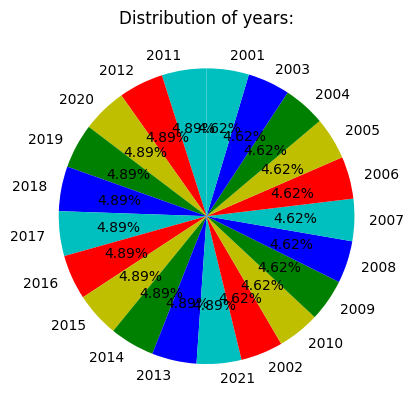

In [ ]:
# Calculate the frequencies of target names
Year_counts = df_crimes['Year'].value_counts()

# Prepare data for the pie chart
labels = Year_counts.index.to_list()
sections = Year_counts.to_numpy()
colors = ['c', 'r', 'y','g','b']

# Create a pie chart
plt.pie(sections, labels=labels, colors = colors, startangle=90, autopct='%1.2f%%')

# Add title and show the pie chart
plt.title('Distribution of years:')
plt.show()

In [ ]:
# Check for missing values
missing_values = df_crimes.isnull().sum()
print(missing_values)

# Check for duplicate rows
duplicate_rows = df_crimes[df_crimes.duplicated(keep=False)]
print(duplicate_rows)

State    0
Year     0
Rape     0
K&A      0
DD       0
AoW      0
AoM      0
DV       0
WT       0
dtype: int64
Empty DataFrame
Columns: [State, Year, Rape, K&A, DD, AoW, AoM, DV, WT]
Index: []


We can see there are no "Null" values or duplicated rows.

To see the boxplots better, we will adress 7 years at a time instead of every year individually.

In [ ]:
def group_years(year):
    if 2001 <= year <= 2007:
        return '2001-2007'
    elif 2008 <= year <= 2014:
        return '2008-2014'
    elif 2015 <= year <= 2021:
        return '2015-2021'

df_crimes['Year_group'] = df_crimes['Year'].apply(group_years)

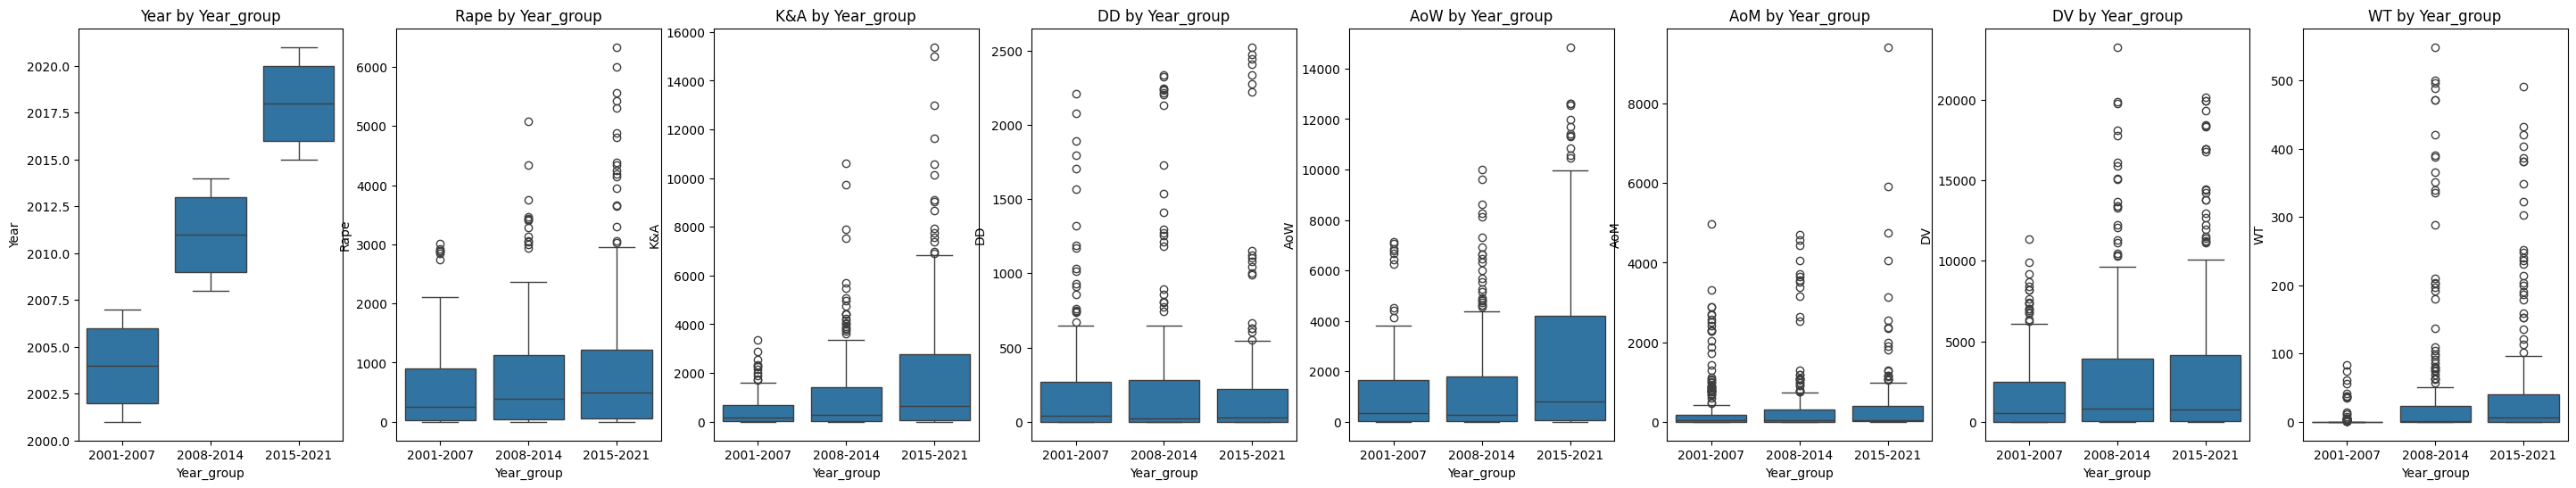

In [ ]:
# Boxplots of the data
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(df_crimes.select_dtypes(include=['int64', 'float64']).columns), figsize=(36, 6))

# Iterate through each numerical column
for i, column in enumerate(df_crimes.select_dtypes(include=['int64', 'float64']).columns):
    # Create a boxplot for each Year_group value
    sns.boxplot(x="Year_group", y=column, data=df_crimes, ax=axes[i])
    axes[i].set_title(f"{column} by Year_group")

# Show the plot
plt.show()

Dealing with outliers

In [ ]:
# Detect and remove outliers:
# Calculate the z-score for each numerical column
z_scores = df_crimes.select_dtypes(include=['int64', 'float64']).apply(lambda x: (x - x.mean()) / x.std())

# Define a threshold for outlier detection
threshold = 2

# Find the indices of outlier rows
outlier_indices = (z_scores > threshold).any(axis=1)

# Filter out the rows that are not outliers
df_crimes_cleaned = df_crimes[~outlier_indices]

# Verify the outliers were removed
print(f"Cleaned dataset shape: {df_crimes_cleaned.shape}")

Cleaned dataset shape: (585, 10)


In [ ]:
df_crimes = df_crimes_cleaned

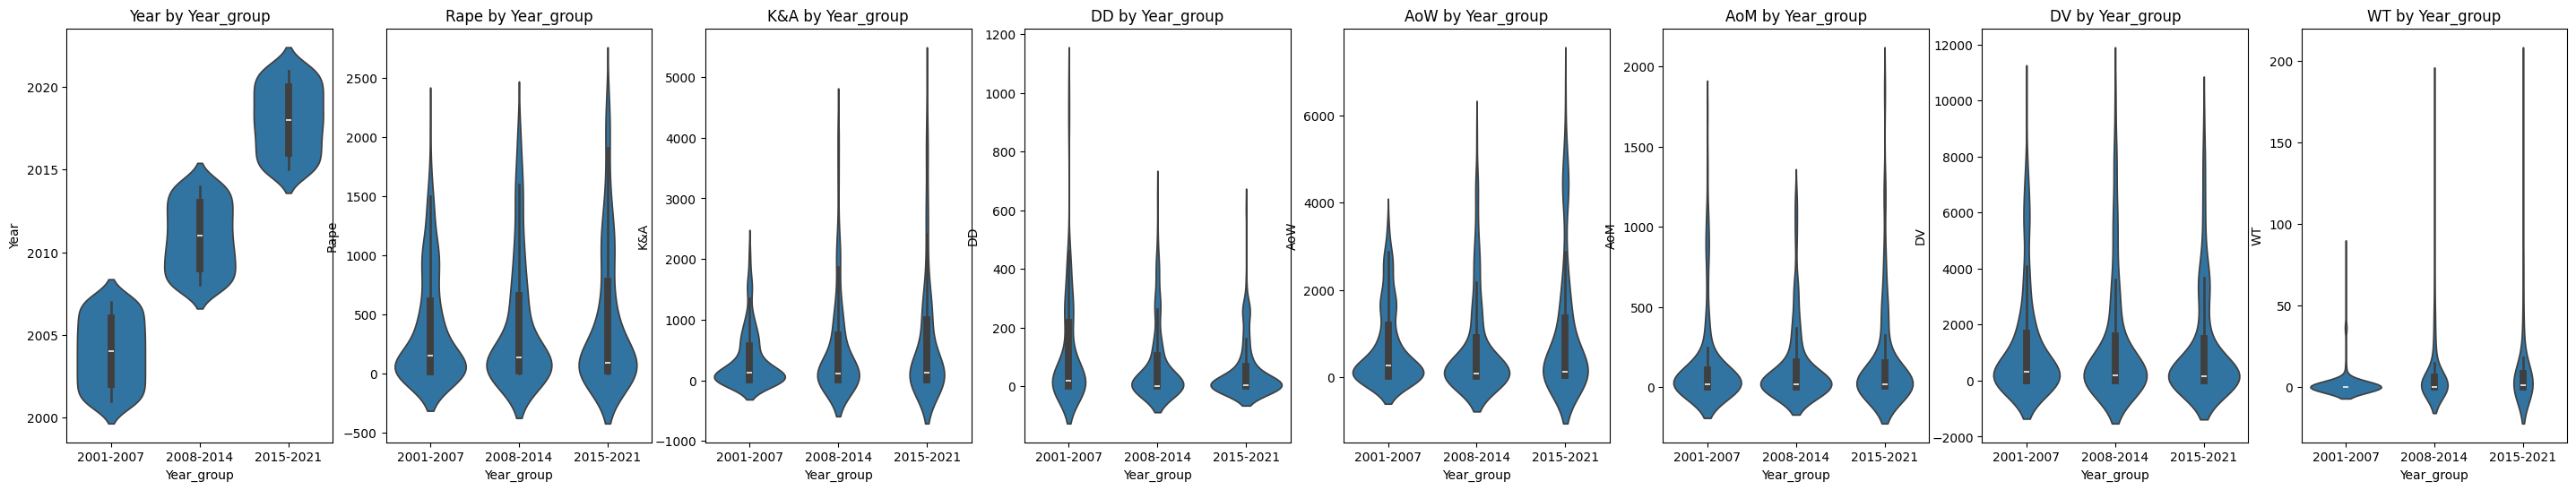

In [ ]:
# Violinplots of the data
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(df_crimes.select_dtypes(include=['int64', 'float64']).columns), figsize=(36, 6))

# Iterate through each numerical column
for i, column in enumerate(df_crimes.select_dtypes(include=['int64', 'float64']).columns):
    # Create a violinplot for each Year_group value
    sns.violinplot(x="Year_group", y=column, data=df_crimes, ax=axes[i])
    axes[i].set_title(f"{column} by Year_group")

# Show the plot
plt.show()

As we can see, most of the plots looks like they are not distributes normally.

We can also see there is no significant difference between the years. To check this formaly, we will do an 'anova' test:

In [ ]:
from sklearn.feature_selection import f_classif

X = df_crimes.drop(columns=['Year_group', 'State', 'Year'])
y = df_crimes['Year_group']

# Perform ANOVA F-test for each feature
f_values, p_values = f_classif(X, y)

# Create a DataFrame to store the results
anova_results = pd.DataFrame({'feature': X.columns,'f_value': f_values,'p_value': p_values})

# Sort the DataFrame by p-value
anova_results = anova_results.sort_values(by='p_value', ascending=True)

# Print the results
print(anova_results)

  feature    f_value   p_value
6      WT  11.759221  0.000010
2      DD  11.131160  0.000018
1     K&A   7.415397  0.000661
3     AoW   4.451643  0.012059
0    Rape   0.944579  0.389438
4     AoM   0.552027  0.576083
5      DV   0.259074  0.771855


We can see that three plots are with a sufficient p-value to be distributed normally: K&A, AoW, WT.

Let's try to see how different states affect crimes against women.

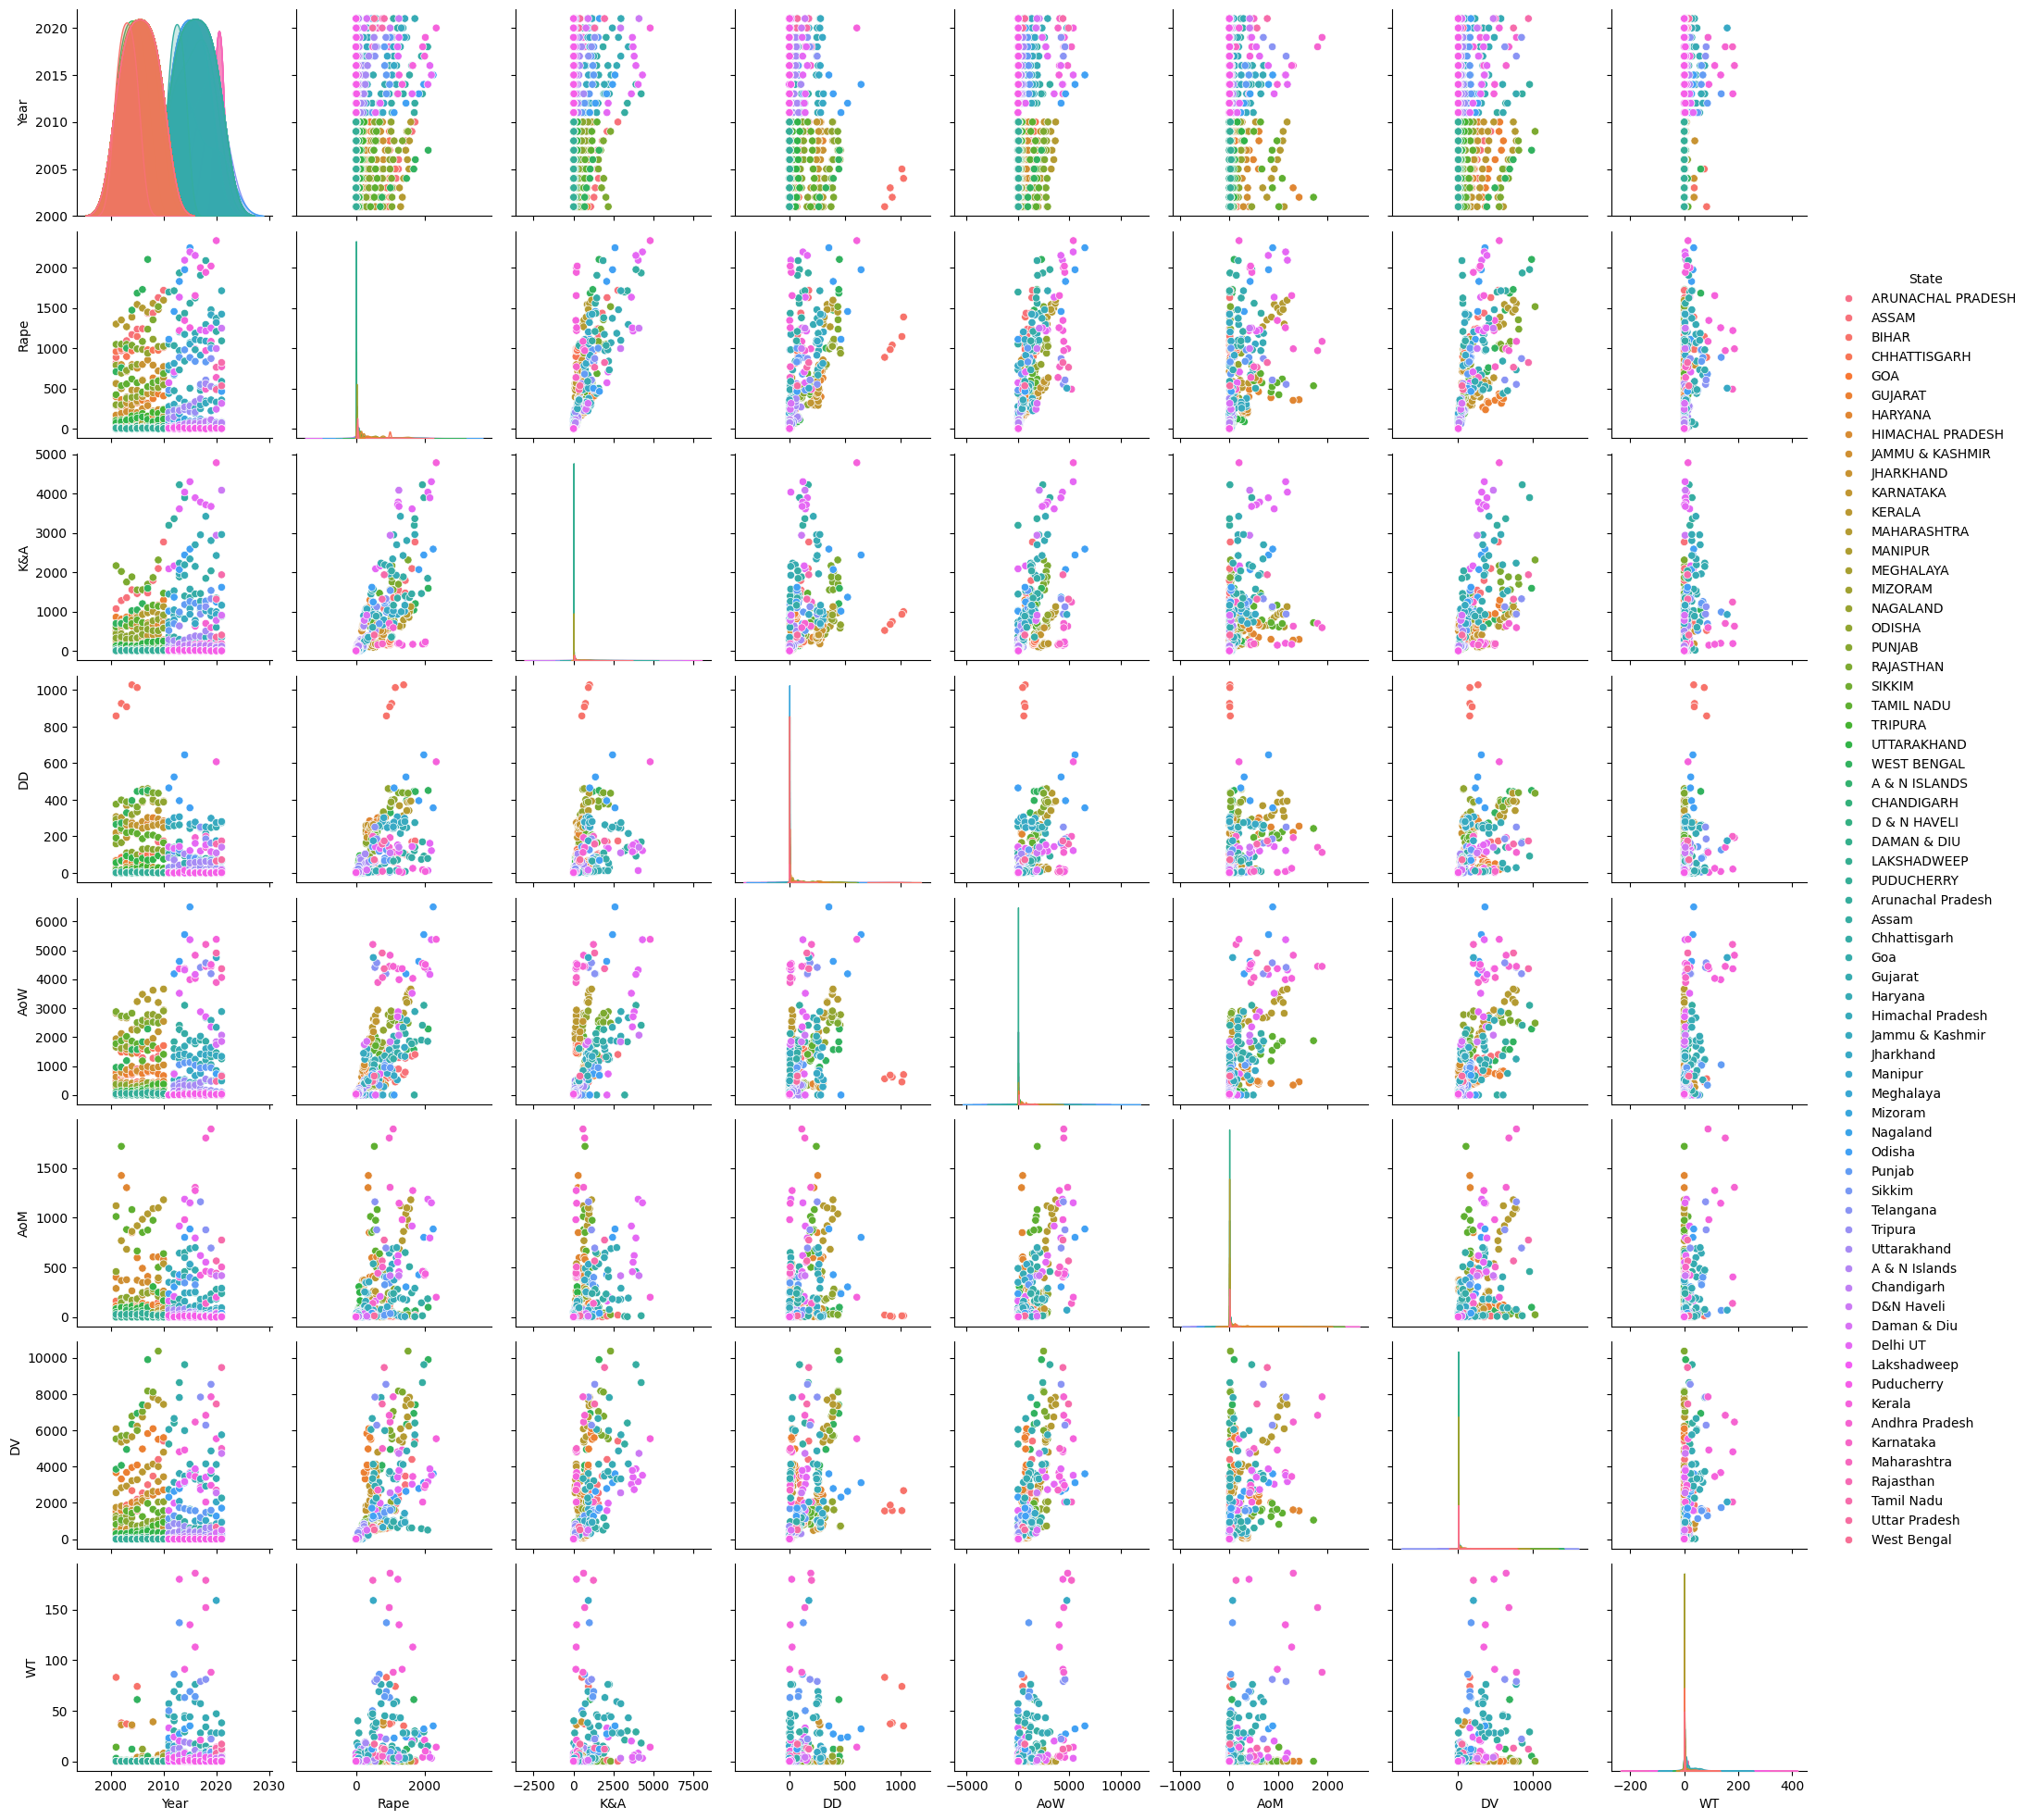

In [ ]:
import matplotlib.pyplot as plt
sns.pairplot(df_crimes, hue="State")
plt.show()

As we can see, we have to many parameters to see anything in the pairplot. therefore, we will try using PCA to reduce dimensions.

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA instance with the desired number of components
pca = PCA(n_components=3)

# Fit the PCA instance to the data
pca.fit(X)

# Transform the data using the fitted PCA instance
X_reduced = pca.transform(X)

# Print the shape of the reduced data
print(X_reduced.shape)

(585, 3)


[0.84017314 0.09183854 0.04987859]
[0.84017314 0.93201168 0.98189027]


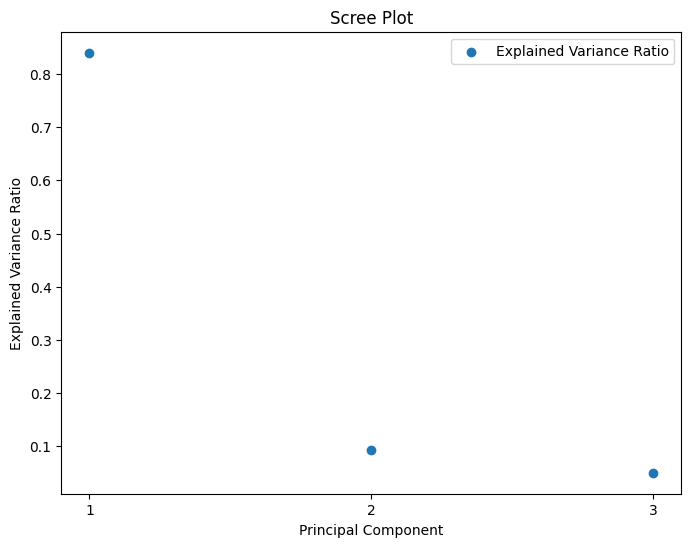

In [ ]:
# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio
print(explained_variance_ratio)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Print the cumulative explained variance ratio
print(cumulative_explained_variance_ratio)

# Create a scree plot to visualize the explained variance ratio for each principal component
plt.figure(figsize=(8, 6))
plt.scatter(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance Ratio')

# Explicitly set natural numbers on the x-axis
plt.xticks(range(1, len(explained_variance_ratio) + 1))

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()

Now we will present the PCA

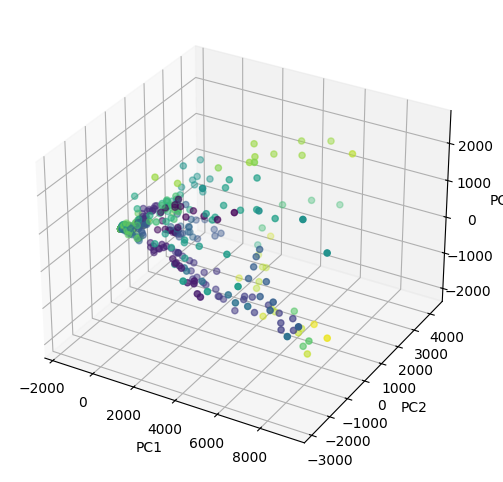

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

State = df_crimes['State'].unique()
color_map = {name: idx for idx, name in enumerate(State)}
colors = [color_map[name] for name in df_crimes['State']]
# Scatter plot of the PCA results, colored by the State feature
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=colors, cmap='viridis')

# Set the labels for the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Show the plot
plt.show()

In [ ]:
from plotly.express import scatter_3d

# Create a 3D scatter plot with interactive features
fig = scatter_3d(X_reduced, x=0, y=1, z=2, color=df_crimes['State'], opacity=0.8)

# Update the layout to show the scene
fig.update_layout(scene=dict(
    xaxis_title='PC1',
    yaxis_title='PC2',
    zaxis_title='PC3'
))

# Show the plot
fig.show()

Coloring the new plot by states gives us zero value. Let's try using clustering to see if the data can be seperated using things we haven't used yet.

               State  Year  Rape   K&A   DD   AoW  AoM    DV  WT Year_group  \
1  ARUNACHAL PRADESH  2001    33    55    0    78    3    11   0  2001-2007   
2              ASSAM  2001   817  1070   59   850    4  1248   0  2001-2007   
3              BIHAR  2001   888   518  859   562   21  1558  83  2001-2007   
4       CHHATTISGARH  2001   959   171   70  1763  161   840   0  2001-2007   
5                GOA  2001    12     6    2    17    7    11   0  2001-2007   

   cluster  
1        0  
2        3  
3        3  
4        3  
5        0  


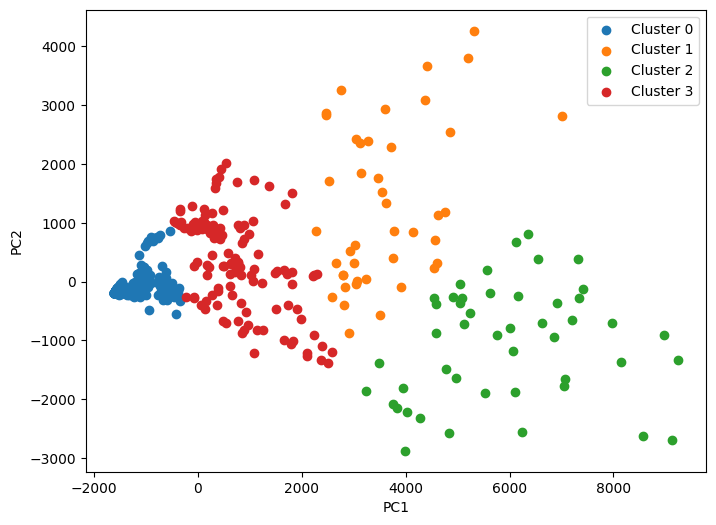

In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 4

# Create a KMeans instance
kmeans = KMeans(n_clusters=num_clusters)

# Fit the KMeans instance to the data
kmeans.fit(X_reduced)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
df_crimes['cluster'] = cluster_labels

# Print the DataFrame
print(df_crimes.head())

# Create a scatter plot of the clusters
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(num_clusters):
    ax.scatter(X_reduced[cluster_labels == i, 0], X_reduced[cluster_labels == i, 1], label=f'Cluster {i}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()



Different way to do PCA:

(585, 2)


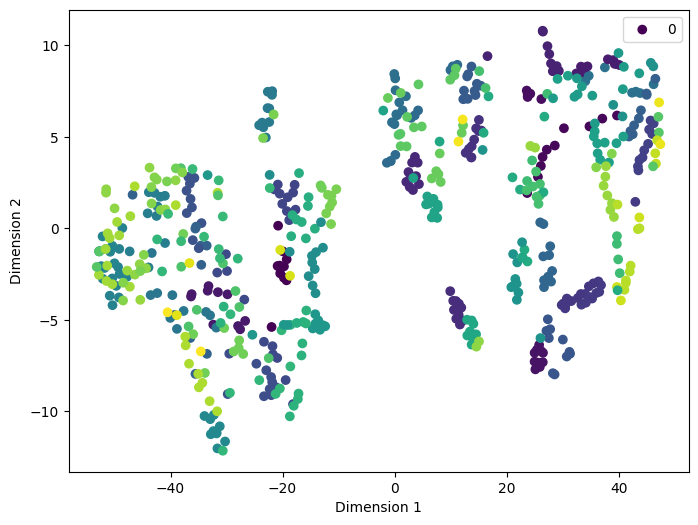

In [ ]:
from sklearn.manifold import TSNE

# Create a TSNE instance with the desired number of components
tsne = TSNE(n_components=2)

# Fit the TSNE instance to the data
tsne.fit(X)

# Transform the data using the fitted TSNE instance
X_tsne = tsne.fit_transform(X)

# Print the shape of the reduced data
print(X_tsne.shape)

# Create a scatter plot of the TSNE results, colored by the State feature
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap='viridis')

# Set the labels for the axes
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(colors)

# Show the plot
plt.show()

We can see that even with TNSE we have trouble finding any seperation at all.
So from now on we will use a different dataset.